In [14]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import blob_dog
import torch

In [ ]:
def pix2ndc(p,s):
    return (2*p +1)/s -1

h, w = 1921, 1073

projection_full = torch.tensor([[ 1.2347, -0.3155,  0.6432,  0.6431],
        [ 1.0517,  0.7530, -0.2665, -0.2664],
        [-0.7158,  0.5621,  0.7180,  0.7179],
        [ 0.8998, -1.8877,  3.9454,  3.9551]])
means_2d = torch.tensor([[   0.0000,    0.0000],
        [   0.0000,    0.0000],
        [   0.0000,    0.0000],
        [ 566.0210, 1040.1997],
        [   0.0000,    0.0000],
        [   0.0000,    0.0000],
        [ 480.4791, 1019.8796],
        [   0.0000,    0.0000],
        [ 180.9700, 1055.9210],
        [   0.0000,    0.0000]], requires_grad=True)

means_2d_new = torch.ones_like(means_2d)
means_2d_new[:,0], means_2d_new[:,1] = pix2ndc(means_2d[:,0],w), pix2ndc(means_2d[:,1],h)

print(f"new means_2d = \n {means_2d_new}")

depths = torch.tensor([0.0000, 0.0000, 0.0000, 5.4124, 0.0000, 0.0000, 3.6705, 0.0000, 9.4935,
        0.0000])
means_3d = torch.tensor([[-1.9686, -5.0952,  8.4925],
        [-7.0956, -0.8330,  3.4324],
        [-3.6041,  3.3491,  2.8043],
        [-0.0486,  1.2050,  2.5206],
        [-7.4773, -0.5681,  3.6143],
        [-7.0176, -0.3949,  3.8820],
        [-1.3654,  1.2697,  1.2979],
        [-6.6321, -2.4209,  0.9914],
        [-0.1703, -1.7058,  7.2341],
        [-1.7995, -5.9542,  7.3705]])

def get_mean_3d(mean_2d, depth, projection_full, w, h):
    """
    Inputs:-
        mean_2d - 2d prixel centroid values of blobs
        depth - Average depth tensor (use knn to get the neighbours and get an average depth value for blobs)
        projection_full - Projection_full matrix of camera viewpoint (projection_mat @ view_mat)
        w - image width
        h - image hight
    Output
        X - 3d coordinates w.r.t world coordinates
    """
    size = mean_2d.shape[0]
    # Converting pixel values to ndc
    means_2d_new = torch.ones_like(mean_2d)
    means_2d_new[:,0], means_2d_new[:,1] = pix2ndc(mean_2d[:,0],w), pix2ndc(mean_2d[:,1],h)

    p = projection_full.T[torch.tensor([0,1,3])][:,:3]  # In 3d gaussian splatting, they have used column prioritizing
    b = torch.ones(size,3)
    b[:,:2] = means_2d_new.detach()*depth.reshape(size,1)
    b[:,2] =  depth
    b = b - projection_full.T[torch.tensor([0,1,3])][:,3]
    X = np.ones((size,3))
    for i in range(size):
         X[i], res, r, s = torch.linalg.lstsq(p, b[i], rcond=None)
    return torch.tensor(X, requires_grad=True) 

#x = get_mean_3d(means_2d_new, depths, projection_full)

def knn_2d(blob_xy, gauss_xy, k):
    device = gauss_xy.device
    blob_xy = blob_xy.to(device)
    gauss_xy = gauss_xy.to(device)
    dists = torch.cdist(blob_xy.float(), gauss_xy.float(), p=2)  # Compute pairwise Euclidean distances
    knn_dists, knn_indices = torch.topk(dists, k, dim=1, largest=False)
    return knn_indices, knn_dists


def get_xyz(knn_indices, gauss_xyz):
    """
    Inputs:-
        knn_indices - indices of k nearest neighbor gaussians 
        gauss_xyz - gaussian 3d coordinates
    Output:-
        average_xyz values
    """
    knn_xyz = gauss_xyz[knn_indices]
    return torch.mean(knn_xyz, dim=1)



new means_2d = 
 tensor([[-0.9991, -0.9995],
        [-0.9991, -0.9995],
        [-0.9991, -0.9995],
        [ 0.0560,  0.0835],
        [-0.9991, -0.9995],
        [-0.9991, -0.9995],
        [-0.1035,  0.0623],
        [-0.9991, -0.9995],
        [-0.6618,  0.0999],
        [-0.9991, -0.9995]], grad_fn=<CopySlices>)


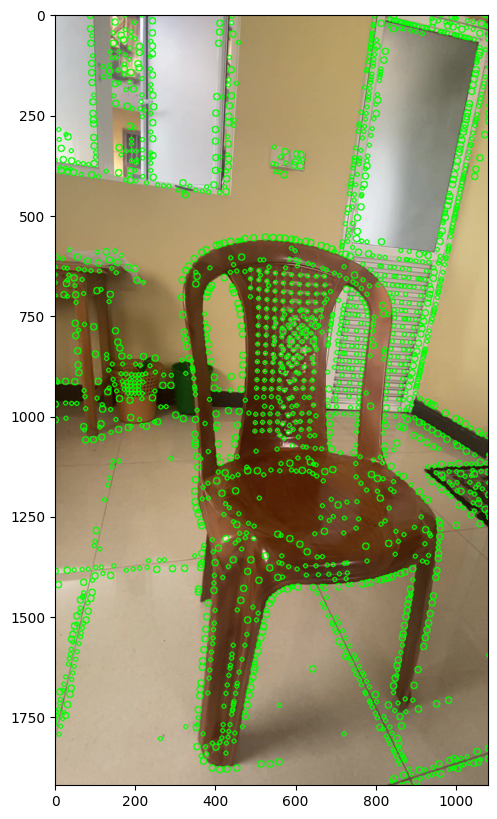

blobs shape =  (1881, 3)


In [16]:
def detect_blobs_dog(image, min_blob_size, max_blob_size, num_intervals):
    """
    Detects blobs in an image using Difference of Gaussian (DoG).

    Parameters:
        image (ndarray): Input image read using OpenCV (BGR format).
        min_blob_size (float): Minimum size (in pixels) of blobs to detect.
        max_blob_size (float): Maximum size (in pixels) of blobs to detect.
        num_intervals (int): Number of intervals to divide the blob size range.

    Returns:
        blobs (ndarray): Array of detected blobs, with each blob represented as [y, x, r].
                         (y, x) are the centroid coordinates, and r is the radius.
        output_image (ndarray): Image with detected blobs drawn.
    """
    # Convert image to grayscale if it is not already
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) if len(image.shape) == 3 else image
    
    # Detect blobs using the Difference of Gaussian (DoG) method
    blobs = blob_dog(gray_image, 
                     min_sigma=min_blob_size / np.sqrt(2), 
                     max_sigma=max_blob_size / np.sqrt(2), 
                     sigma_ratio=1.6, 
                     threshold=0.01)
    
    # Compute radii in the 3rd column as sigma * sqrt(2)
    blobs[:, 2] = blobs[:, 2] * np.sqrt(2)
    
    # Draw blobs on the image for output
    output_image = image.copy()
    height, width = gray_image.shape    # To shift the center of origine to bottom left
    # x, y correction (the output of blob_dog is like (y,x,r))
    blobs_new = np.empty_like(blobs)
    blobs_new[:,0], blobs_new[:,1], blobs_new[:,2] = blobs[:,1], height-blobs[:,0], blobs[:,2]

    for blob in blobs:
        y, x, r = blob
        y = y#max(height - y,0)   # To shift the center of origine to bottom left
        cv2.circle(output_image, (int(x), int(y)), int(r), (0, 255, 0), 2)

    return blobs_new, output_image

# Example of how to use the function
# Load image using OpenCV
image_path = "/home/lathika/Workspace/Data_Sets/My_Data_sets/Chair/input/0034.jpg"
image = cv2.imread(image_path)

# Define blob detection parameters
min_blob_size = 5  # Minimum blob size (in pixels)
max_blob_size = 8  # Maximum blob size (in pixels)
num_intervals = 5  # Number of intervals to divide the size range

# Detect blobs 
blobs, output_image = detect_blobs_dog(image, min_blob_size, max_blob_size, num_intervals)


plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
plt.show()

"""
# Output the blobs details: centroid (x, y) and radius
for i, blob in enumerate(blobs):
    print(f"Blob {i+1}: Centroid = ({blob[1]:.2f}, {blob[0]:.2f}), Radius = {blob[2]:.2f}")
    """

print(f"blobs shape =  {blobs.shape}")



In [ ]:
# Check if a GPU is available
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

means_2d_1 = np.random.randint([0,0],[w,h],(20,2))
blobs_1 = blobs[0:10]
means_2d_1 = torch.tensor(means_2d_1,device=device)
blobs_1_xy = torch.tensor(blobs_1[:,:2],device=device)
radii =  torch.tensor(blobs_1[:,2],device=device)

w_min, w_max = int(w*0.01), int(w*0.99)
h_min, h_max = int(h*0.01), int(h*0.99)

mask = torch.logical_and(torch.tensor([w_max,h_max],device=device)>blobs_1_xy ,blobs_1_xy>torch.tensor([w_min,h_min],device=device))
mask = torch.logical_and(mask[:,0], mask[:,1])
print(mask)

print(blobs_1_xy[mask])
blobs_1_xy = blobs_1_xy[mask]
radii= radii[mask] 

indices,  _ = knn_2d(blobs_1_xy, means_2d_1, k=3)
print(indices)
depths_1 = np.random.uniform(9,13, size =20)
depths_1 = torch.tensor(depths_1,device=device)
depth = torch.mean(depths_1[indices],dim=1)
print(f"depths_1 = {depths_1}")
print(f"selected depths = depths_1")


def get_mean_3d_cuda(blobs_xy, depth, projection_full, w, h):
    """
    Inputs:
        blobs_xy - 2D pixel centroid values of blobs
        depth - Average depth tensor (use knn to get neighbors and get an average depth value for blobs)
        projection_full - Projection matrix of camera viewpoint (projection_mat @ view_mat)
        w - Image width
        h - Image height
    Output:
        X - 3D coordinates with respect to world coordinates
    """
    device = blobs_xy.device  # Assuming blobs_xy, depth, and projection_full are on the same device (CUDA)

    # Number of blobs
    size = blobs_xy.shape[0]

    # Converting pixel values to NDC (Normalized Device Coordinates)
    blobs_xy_new = torch.ones_like(blobs_xy, device=device)
    blobs_xy_new[:, 0], blobs_xy_new[:, 1] = pix2ndc(blobs_xy[:, 0], w), pix2ndc(blobs_xy[:, 1], h)

    # Preparing matrices for Ax = b
    p = projection_full.T[torch.tensor([0, 1, 3], device=device)][:, :3]  # Column prioritizing
    b = torch.ones(size, 3, device=device)  # b matrix in Ax = b
    b[:, :2] = blobs_xy_new * depth.view(size, 1)
    b[:, 2] = depth

    # Adjust b by subtracting translation part of projection
    b = b - projection_full.T[torch.tensor([0, 1, 3], device=device)][:, 3]

    # Solve Ax = b in batch mode
    # p needs to be expanded to match the size of b for batch lstsq
    p_batch = p.unsqueeze(0).expand(size, -1, -1)  # Expanding p to shape (size, 3, 3)
    b_batch = b.unsqueeze(-1)  # Making b shape (size, 3, 1)

    # Use torch.linalg.lstsq on CUDA with the `gels` driver (default for CUDA)
    X= torch.linalg.lstsq(p_batch, b_batch).solution

    # Remove the extra dimension added for lstsq compatibility
    X = X.squeeze(-1)

    return X

x = get_mean_3d(blobs_1_xy, depth, projection_full, w, h)

blobs_1_xy = blobs_1_xy.to(device='cuda')
depth = depth.to(device='cuda')
projection_full = projection_full.to('cuda')

x = get_mean_3d_cuda(blobs_1_xy, depth, projection_full, w, h)


tensor([ True,  True,  True,  True,  True, False,  True,  True,  True,  True],
       device='cuda:0')
tensor([[ 523.,  572.],
        [ 580.,  880.],
        [ 590.,  847.],
        [ 494.,  615.],
        [ 425.,  615.],
        [ 620., 1043.],
        [ 593., 1064.],
        [ 566.,  901.],
        [ 580.,  922.]], device='cuda:0', dtype=torch.float64)
tensor([[ 4,  0, 12],
        [ 0,  4, 18],
        [ 0,  4,  5],
        [ 4,  0, 12],
        [ 4, 12,  0],
        [ 0, 14, 15],
        [ 0, 14, 15],
        [ 0,  4, 18],
        [ 0,  4, 18]], device='cuda:0')
depths_1 = tensor([ 9.8290, 10.4095, 11.0182,  9.7603, 10.1175, 12.8699, 10.5286, 12.5458,
        10.7870,  9.5401, 10.2381,  9.3842, 10.1066, 11.8910, 10.8987, 12.6719,
        11.8023, 12.1903, 12.9733, 12.4152], device='cuda:0',
       dtype=torch.float64)
selected depths = depths_1


In [32]:
import math

def fov2focal(fov, pixels):
    return pixels / (2 * math.tan(fov / 2))

def get_scalings(viewpoint_cam, rad_pix, width, hight, depth):
    focal_len_x_pixels = fov2focal(viewpoint_cam.FoVx, width)
    focal_len_y_pixels = fov2focal(viewpoint_cam.FoVy, hight)
    focal_len_pixels = 0.5*(focal_len_x_pixels + focal_len_y_pixels)  
    scale_factor = depth / focal_len_pixels 
    print(f"scale fac shape == {scale_factor.shape}\n") 
    print(f"scale fac  == {scale_factor}\n") 
    print(f"rad shape == {rad_pix.shape}\n") 
    print(f"rad  == {rad_pix}\n") 
    blob_scale = scale_factor*rad_pix
    return blob_scale

class viewpointCamera:
    def __init__(self, FoVx, FoVy):
        self.FoVx = FoVx
        self.FoVy = FoVy

viewpoint_cam = viewpointCamera
viewpoint_cam.FoVx = 1.0271822897664995
viewpoint_cam.FoVy = 1.5795791320341483 

scales = get_scalings(viewpoint_cam,radii, w,h, depth)

print(scales)

scale fac shape == torch.Size([9])

scale fac  == tensor([0.0111, 0.0114, 0.0114, 0.0114, 0.0114, 0.0129, 0.0129, 0.0114, 0.0114],
       device='cuda:0', dtype=torch.float64)

rad shape == torch.Size([9])

rad  == tensor([8., 5., 5., 5., 8., 5., 5., 5., 5.], device='cuda:0',
       dtype=torch.float64)

tensor([0.0886, 0.0568, 0.0568, 0.0568, 0.0909, 0.0646, 0.0646, 0.0568, 0.0568],
       device='cuda:0', dtype=torch.float64)


In [55]:
a = np.random.randint(3,10,(3,5,4))
print(a)
print(np.transpose(a,axes=(1,2,0)))

[[[7 8 9 5]
  [9 9 5 6]
  [9 7 4 6]
  [6 4 9 8]
  [9 9 8 9]]

 [[9 3 5 3]
  [9 5 6 9]
  [4 9 7 6]
  [8 7 4 7]
  [6 6 9 3]]

 [[8 9 8 9]
  [3 9 7 8]
  [7 5 4 4]
  [5 7 7 6]
  [3 7 6 3]]]
[[[7 9 8]
  [8 3 9]
  [9 5 8]
  [5 3 9]]

 [[9 9 3]
  [9 5 9]
  [5 6 7]
  [6 9 8]]

 [[9 4 7]
  [7 9 5]
  [4 7 4]
  [6 6 4]]

 [[6 8 5]
  [4 7 7]
  [9 4 7]
  [8 7 6]]

 [[9 6 3]
  [9 6 7]
  [8 9 6]
  [9 3 3]]]
